In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit 
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")



In [ ]:
# 1. Load the dataset
df = pd.read_csv("Epileptic Seizure Recognition.csv")
print('Shape:', df.shape)
display(df.head())

Shape: (11500, 180)


,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [80]:
# Extract subject_id from the first (unnamed) column
# Example: "X21.V1.791" : extract "791"

df['subject_id'] = (
    df.iloc[:, 0]               
      .astype(str)               
      .str.split('.')            
      .str[-1]                   
      .str.replace('V', '', regex=True)  
      .astype(int)               
)

subject_counts = df['subject_id'].value_counts()

print("Total rows:", len(df))
print("Unique subjects:", df['subject_id'].nunique())

print("\nWindow count per subject:")
print(subject_counts)

print("\nSubjects with 46 windows (if any):")
duplicated_subjects = subject_counts[subject_counts == 46]
print(duplicated_subjects.index.tolist())

print("\nDistribution of window counts:")
print(subject_counts.value_counts().sort_index())


Total rows: 11500
Unique subjects: 495

Window count per subject:
subject_id
12     46
14     46
13     46
11     46
1      46
       ..
72     23
744    23
733    23
374    23
54     23
Name: count, Length: 495, dtype: int64

Subjects with 46 windows (if any):
[12, 14, 13, 11, 1]

Distribution of window counts:
count
23    490
46      5
Name: count, dtype: int64


In [81]:
df.head()


,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X171,X172,X173,X174,X175,X176,X177,X178,y,subject_id
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-15,-31,-77,-103,-127,-116,-83,-51,4,791
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,150,146,152,157,156,154,143,129,1,924
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,64,48,19,-12,-30,-35,-35,-36,5,1
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-81,-80,-77,-85,-77,-72,-69,-65,5,60
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,2,-12,-32,-41,-65,-83,-89,-73,5,54


In [82]:
df.drop('Unnamed', axis=1, inplace=True)

In [83]:
label_col ='y'
label_map = {1:'Seizure',2:'TumorRegion',3:'HealthyRegion',4:'EyesClosed',5:'EyesOpen'}
df['label_name'] = df[label_col].map(label_map)
df['is_seizure'] = (df[label_col]==1).astype(int)


print(df[label_col].value_counts())


y
4    2300
1    2300
5    2300
2    2300
3    2300
Name: count, dtype: int64


In [84]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X173,X174,X175,X176,X177,X178,y,subject_id,label_name,is_seizure
0,135,190,229,223,192,125,55,-9,-33,-38,...,-77,-103,-127,-116,-83,-51,4,791,EyesClosed,0
1,386,382,356,331,320,315,307,272,244,232,...,152,157,156,154,143,129,1,924,Seizure,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,19,-12,-30,-35,-35,-36,5,1,EyesOpen,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-77,-85,-77,-72,-69,-65,5,60,EyesOpen,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,-32,-41,-65,-83,-89,-73,5,54,EyesOpen,0


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 182 entries, X1 to is_seizure
dtypes: int64(181), object(1)
memory usage: 16.0+ MB


In [86]:
print(df.isnull().sum().sum())

0


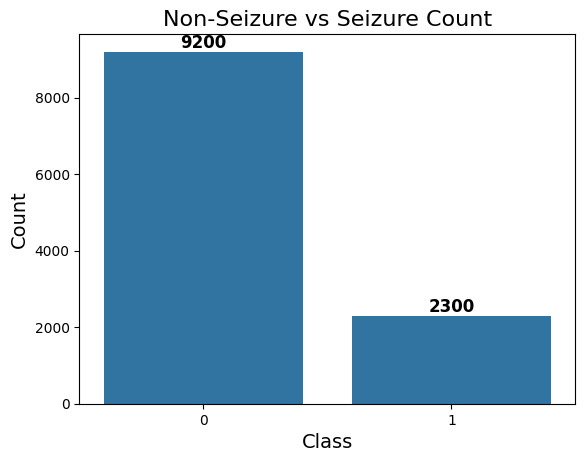

In [87]:
ax = sns.countplot(x=df['is_seizure'])
ax.bar_label(ax.containers[0], fontsize=12, weight="bold")

plt.title("Non-Seizure vs Seizure Count", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.show()

In [88]:
vc = df[label_col].value_counts().sort_index()
vc_percent = 100*vc/vc.sum()
class_df = pd.DataFrame({'count':vc, 'percent':vc_percent, 'name':[label_map[i] for i in vc.index]})
class_df

,count,percent,name
y,,,
1,2300,20.0,Seizure
2,2300,20.0,TumorRegion
3,2300,20.0,HealthyRegion
4,2300,20.0,EyesClosed
5,2300,20.0,EyesOpen


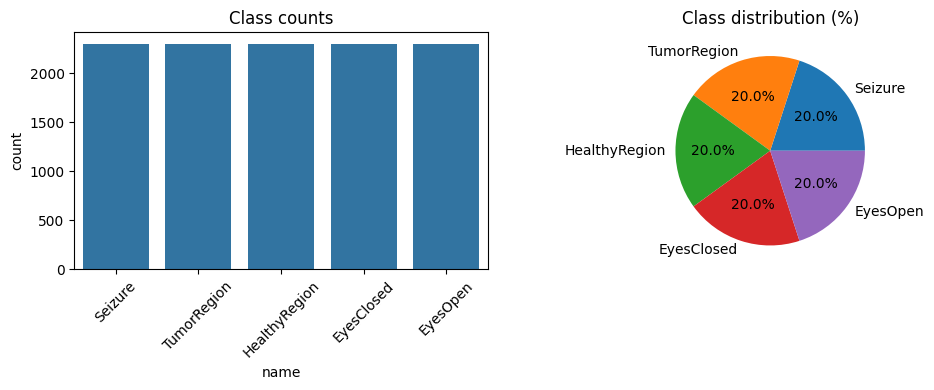

In [89]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.barplot(x=class_df['name'], y=class_df['count'])
plt.xticks(rotation=45)
plt.title('Class counts')

plt.subplot(1,2,2)
plt.pie(class_df['count'], labels=class_df['name'], autopct='%1.1f%%')
plt.title('Class distribution (%)')
plt.tight_layout()
plt.show()

In [90]:
print('Totall Mean VALUE for Epiletic: {}'.format((df[df['is_seizure'] == 1].describe().mean()).mean()))
print('Totall Std VALUE for Epiletic: {}'.format((df[df['is_seizure'] == 1].describe().std()).std()))

Totall Mean VALUE for Epiletic: 292.47676660362157
Totall Std VALUE for Epiletic: 71.71977496841293


In [91]:
print('Totall Mean VALUE for NON Epiletic: {}'.format((df[df['is_seizure']== 0].describe().mean()).mean()))
print('Totall Std VALUE for NON Epiletic: {}'.format((df[df['is_seizure']== 0].describe().std()).std()))

Totall Mean VALUE for NON Epiletic: 1260.9022982853232
Totall Std VALUE for NON Epiletic: 18.874729334734557


In [92]:
X = df.iloc[:,0:179].values
print(X.shape)
print(X)

(11500, 179)
[[135 190 229 ... -83 -51   4]
 [386 382 356 ... 143 129   1]
 [-32 -39 -47 ... -35 -36   5]
 ...
 [ 14   6 -13 ...  -1  -8   5]
 [-40 -25  -9 ...  59  55   3]
 [ 29  41  57 ...   2  20   4]]


In [93]:
seizure = df.iloc[:,181].values
print(seizure.shape)
print(seizure)

(11500,)
[0 1 0 ... 0 0 0]


In [94]:
seizure_index_list = []
normal_index_list = []
for i in range(len(seizure)):
    if (seizure[i] == 1):
        seizure_index_list.append(i)
    else:
        normal_index_list.append(i)

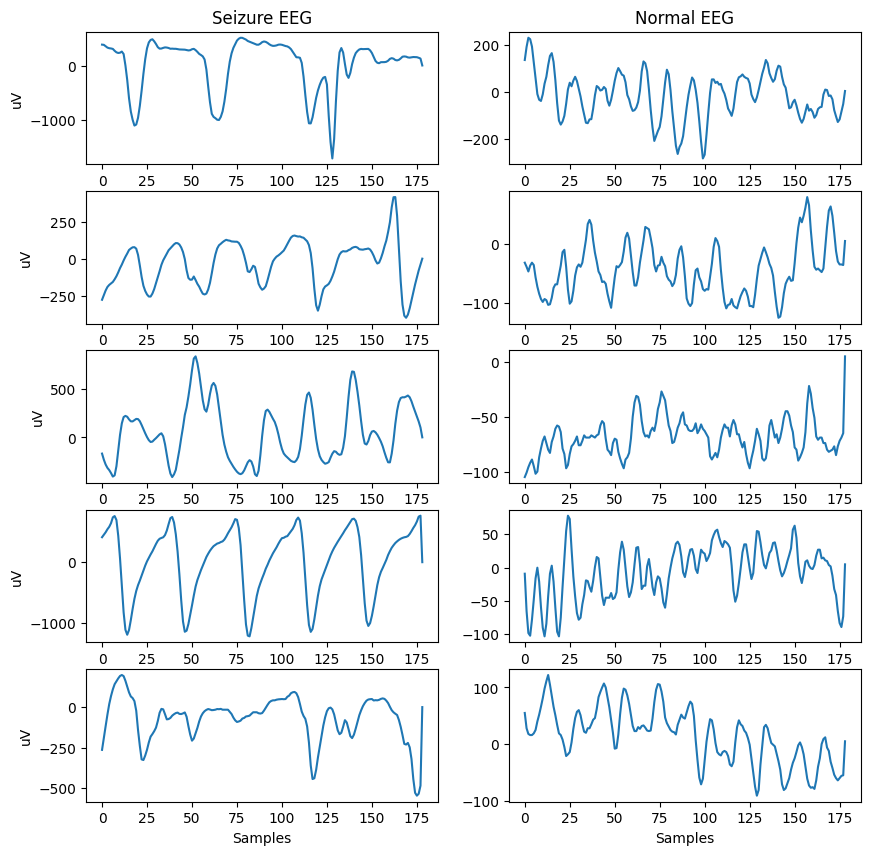

In [95]:
def plot_some_samples(data, label, seizure_index_list, normal_index_list):
    plt.figure(figsize=(10,10))
    plt.subplot(5,2,1)
    plt.title('Seizure EEG')
    plt.plot(X[seizure_index_list[0],:])
    plt.ylabel('uV')
    plt.subplot(5,2,3)
    plt.plot(X[seizure_index_list[1],:])
    plt.ylabel('uV')
    plt.subplot(5,2,5)
    plt.plot(X[seizure_index_list[2],:])
    plt.ylabel('uV')
    plt.subplot(5,2,7)
    plt.plot(X[seizure_index_list[3],:])
    plt.ylabel('uV')
    plt.subplot(5,2,9)
    plt.plot(X[seizure_index_list[4],:])
    plt.ylabel('uV')
    plt.xlabel('Samples')
    plt.subplot(5,2,2)
    plt.title('Normal EEG')
    plt.plot(X[normal_index_list[0],:])
    plt.subplot(5,2,4)
    plt.plot(X[normal_index_list[1],:])
    plt.subplot(5,2,6)
    plt.plot(X[normal_index_list[2],:])
    plt.subplot(5,2,8)
    plt.plot(X[normal_index_list[3],:])
    plt.subplot(5,2,10)
    plt.plot(X[normal_index_list[4],:])
    plt.xlabel('Samples')
plot_some_samples(data=X, label=seizure, seizure_index_list= seizure_index_list, normal_index_list = normal_index_list)

In [96]:
def extract_features(row):
    signal = row.values.astype(float)  
    
    features = {}
    
    # Time-domain features
    features['std'] = np.std(signal)
    features['skew'] = pd.Series(signal).skew()
    features['kurtosis'] = pd.Series(signal).kurtosis()
    
    # Frequency-domain features using Welch
    fs = 178
  
    f, psd = welch(signal, fs=fs)

    
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }
    
    total_power = np.sum(psd) 
    for band_name, (low, high) in bands.items():
        mask = (f >= low) & (f <= high)
        power = np.sum(psd[mask])
        features[f'{band_name}_power'] = power
        features[f'{band_name}_relative'] = power / total_power
    
    features['total_power'] = total_power
    features['spectral_entropy'] = -np.sum((psd/total_power) * np.log2(psd/total_power + 1e-10))
    
    return pd.Series(features)

In [97]:
features_df = df.iloc[:,0:179].apply(extract_features, axis=1)



In [43]:
features_df


,std,skew,kurtosis,delta_power,delta_relative,theta_power,theta_relative,alpha_power,alpha_relative,beta_power,beta_relative,gamma_power,gamma_relative,total_power,spectral_entropy
0,95.455958,-0.206152,0.120682,2916.317079,0.250442,151.119330,0.012978,4378.322540,0.375993,3985.442599,0.342254,60.106482,0.005162,11644.682337,3.344419
1,470.520339,-1.527147,1.437338,162627.714040,0.609155,53616.504971,0.200831,20879.296879,0.078208,29309.661507,0.109785,437.475921,0.001639,266972.794123,3.436251
2,44.214157,0.483895,-0.239697,397.753222,0.261485,338.760063,0.222703,274.025664,0.180146,476.785637,0.313441,6.463764,0.004249,1521.132087,4.283626
3,16.807611,0.717820,1.668476,82.219407,0.325566,27.433115,0.108627,63.859714,0.252866,65.813485,0.260603,1.712636,0.006782,252.543227,4.392852
4,38.594541,-0.472562,-0.207084,355.400046,0.346797,142.010663,0.138573,134.026675,0.130782,305.991781,0.298585,26.154172,0.025521,1024.806356,4.390483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,38.162217,-0.186229,-0.948452,690.623282,0.513110,492.028857,0.365561,33.567296,0.024939,11.103940,0.008250,2.574176,0.001913,1345.956694,2.991203
11496,162.622757,0.009627,0.592759,3158.569434,0.167347,10183.980482,0.539566,3275.953263,0.173566,2199.821268,0.116551,34.867913,0.001847,18874.389435,3.556547
11497,44.041510,0.093827,-0.372551,526.757983,0.319343,44.482467,0.026967,224.968286,0.136385,695.553723,0.421675,98.870695,0.059940,1649.503489,4.264546
11498,63.327764,0.513602,0.309825,732.236538,0.336316,512.682922,0.235475,695.033251,0.319229,183.471199,0.084268,6.894435,0.003167,2177.226836,3.480511


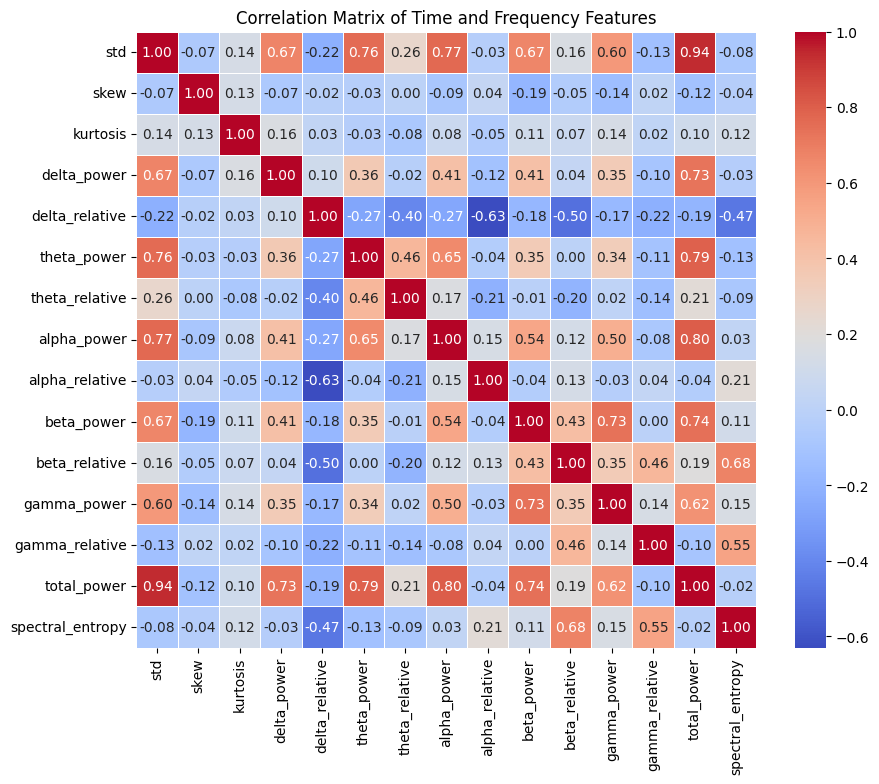

In [98]:
#correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = features_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Time and Frequency Features')
plt.show()

In [33]:
best_features = ['std', 'kurtosis', 'skew', 'spectral_entropy','gamma_power', 'gamma_relative', 'delta_power','delta_relative']
X = features_df[best_features]
y = df['is_seizure']
groups = df['subject_id']

In [34]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]


print(f"Train subjects: {groups.iloc[train_idx].nunique()}")
print(f"Test subjects: {groups.iloc[test_idx].nunique()}")
print(f"Train seizures: {y_train.sum()} / {len(y_train)}")
print(f"Test seizures: {y_test.sum()} / {len(y_test)}")

Train subjects: 396
Test subjects: 99
Train seizures: 1794 / 9177
Test seizures: 506 / 2323


In [35]:
# Scale features
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Logistic Regression

Logistic Regression
Accuracy: 0.9643 | AUC: 0.9849
              precision    recall  f1-score   support

     Seizure       0.97      0.98      0.98      1817
  NO Seizure       0.93      0.91      0.92       506

    accuracy                           0.96      2323
   macro avg       0.95      0.94      0.95      2323
weighted avg       0.96      0.96      0.96      2323



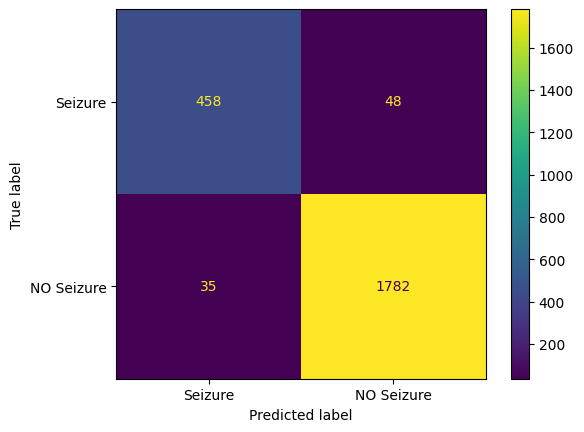

In [36]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print("Logistic Regression")
print(f"Accuracy: {acc:.4f} | AUC: {auc:.4f}")
print(classification_report(y_test, y_pred, target_names=[" Seizure", "NO Seizure"]))

cm = confusion_matrix(y_test, y_pred,labels=[1,0])
ConfusionMatrixDisplay(cm ,display_labels=["Seizure", "NO Seizure"]).plot()

Support Vector Machine

SVM
Accuracy: 0.9630 | AUC: 0.9916
              precision    recall  f1-score   support

  No Seizure       0.98      0.98      0.98      1817
     Seizure       0.92      0.91      0.91       506

    accuracy                           0.96      2323
   macro avg       0.95      0.94      0.95      2323
weighted avg       0.96      0.96      0.96      2323



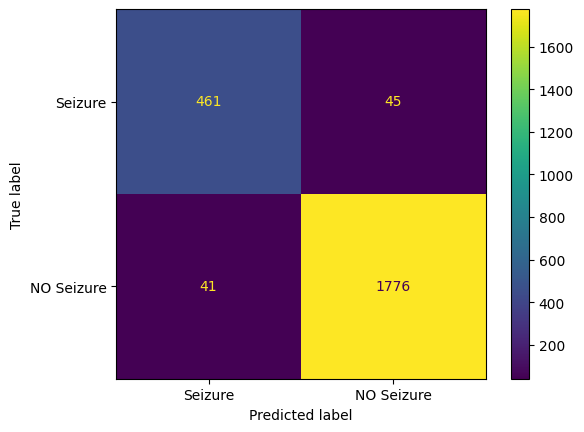

In [37]:
svm = SVC(probability=True, class_weight='balanced')
svm.fit(X_train_scaled, y_train)

y_pred = svm.predict(X_test_scaled)
y_prob = svm.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print("SVM")
print(f"Accuracy: {acc:.4f} | AUC: {auc:.4f}")
print(classification_report(y_test, y_pred, target_names=["No Seizure", "Seizure"]))

cm = confusion_matrix(y_test, y_pred,labels=[1,0])
ConfusionMatrixDisplay(cm ,display_labels=["Seizure", "NO Seizure"]).plot()

DecisionTree

Decision Tree
Accuracy: 0.9669 | AUC: 0.9616
              precision    recall  f1-score   support

  No Seizure       0.98      0.98      0.98      1817
     Seizure       0.93      0.92      0.92       506

    accuracy                           0.97      2323
   macro avg       0.95      0.95      0.95      2323
weighted avg       0.97      0.97      0.97      2323



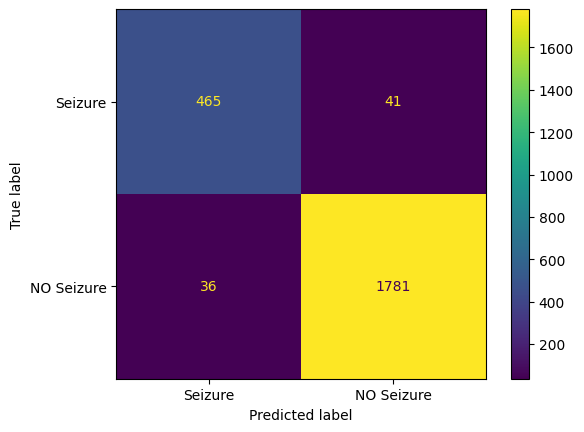

In [38]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=10,            
    min_samples_leaf=5,      
    class_weight='balanced',  
    random_state=42
)


dt.fit(X_train_scaled, y_train)


y_pred = dt.predict(X_test_scaled)
y_prob = dt.predict_proba(X_test_scaled)[:, 1]  


acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print("Decision Tree")
print(f"Accuracy: {acc:.4f} | AUC: {auc:.4f}")
print(classification_report(y_test, y_pred, target_names=["No Seizure", "Seizure"]))

cm = confusion_matrix(y_test, y_pred,labels=[1,0])
ConfusionMatrixDisplay(cm ,display_labels=["Seizure", "NO Seizure"]).plot()
